This file using models to classify or predict which loans will default.

In [10]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

# Import estimators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Import model metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Import cross validation
from sklearn.cross_validation import train_test_split

In [2]:
# Import raw data
rawData = pd.read_csv('default of credit card clients.csv', header=1)
del rawData ['ID']
rawData.rename(columns = {'default payment next month':'default'}, inplace=True)

In [ ]:
# Run out of the box first then again with this change

# Gather 4 values of 'others' in education into one
#credit.EDUCATION.replace([0,4,5,6], [4,4,4,4])
#d = {1:1, 2:2, 3:3, 0:4,5:4,6:4}
#credit.EDUCATION = credit.EDUCATION.replace(d)
#credit.EDUCATION.describe()

In [ ]:
# Consider making Education, Marriage & Sex a categorical value
"""# Encoding categorical data i.e. change yes/no and France/Spain/Germany
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray().astype(int)"""

In [3]:
# Examine structure of raw data set
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


In [4]:
# Select features
features = rawData.iloc[:,0:23]
print('Summary of features sample:')
features[0:5]

Summary of features sample:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [5]:
print('Summary of rawData first 6 rows:')
rawData.iloc[0:5,0:23]

Summary of rawData first 6 rows:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [19]:
# Set dependent variable
depVar = rawData['default']
depVar[0:5,]

0    1
1    1
2    0
3    0
4    0
Name: default, dtype: int64

In [20]:
print(np.cov(rawData))

[[1.70533754e+07 9.78300760e+07 7.51412340e+07 ... 2.04403049e+07
  5.68178674e+07 4.48811333e+07]
 [9.78300760e+07 5.92005884e+08 4.30495457e+08 ... 1.33781723e+08
  3.21504488e+08 2.13976733e+08]
 [7.51412340e+07 4.30495457e+08 3.62022316e+08 ... 1.18549338e+08
  3.04781405e+08 2.64343257e+08]
 ...
 [2.04403049e+07 1.33781723e+08 1.18549338e+08 ... 8.50745659e+07
  1.12757064e+08 9.35082528e+07]
 [5.68178674e+07 3.21504488e+08 3.04781405e+08 ... 1.12757064e+08
  1.03182158e+09 3.87177194e+08]
 [4.48811333e+07 2.13976733e+08 2.64343257e+08 ... 9.35082528e+07
  3.87177194e+08 3.83180996e+08]]


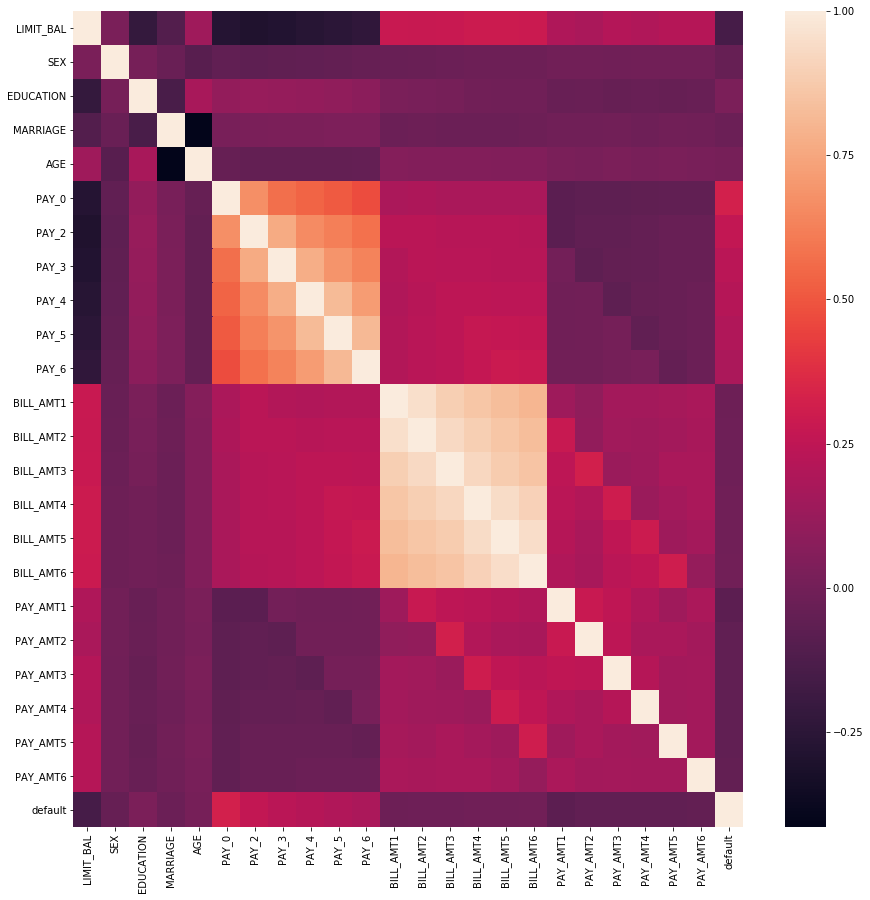

In [36]:
plt.figure(figsize=(15,15)) 
corr = rawData.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

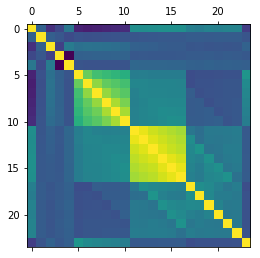

In [22]:
plt.matshow(rawData.corr())

In [15]:
rawData.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
LIMIT_BAL,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
PAY_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


In [37]:
# See the correlations in descending order

core = rawData.corr() # df is the pandas dataframe
c1 = corr.abs().unstack()
c1.sort_values(ascending = False).drop_duplicates()

default    default      1.000000
BILL_AMT2  BILL_AMT1    0.951484
BILL_AMT6  BILL_AMT5    0.946197
BILL_AMT4  BILL_AMT5    0.940134
BILL_AMT3  BILL_AMT2    0.928326
           BILL_AMT4    0.923969
BILL_AMT4  BILL_AMT6    0.900941
BILL_AMT2  BILL_AMT4    0.892482
BILL_AMT1  BILL_AMT3    0.892279
BILL_AMT3  BILL_AMT5    0.883910
BILL_AMT4  BILL_AMT1    0.860272
BILL_AMT2  BILL_AMT5    0.859778
BILL_AMT3  BILL_AMT6    0.853320
BILL_AMT2  BILL_AMT6    0.831594
BILL_AMT5  BILL_AMT1    0.829779
PAY_4      PAY_5        0.819835
PAY_5      PAY_6        0.816900
BILL_AMT1  BILL_AMT6    0.802650
PAY_4      PAY_3        0.777359
PAY_3      PAY_2        0.766552
PAY_6      PAY_4        0.716449
PAY_5      PAY_3        0.686775
PAY_0      PAY_2        0.672164
PAY_2      PAY_4        0.662067
PAY_6      PAY_3        0.632684
PAY_2      PAY_5        0.622780
           PAY_6        0.575501
PAY_3      PAY_0        0.574245
PAY_4      PAY_0        0.538841
PAY_0      PAY_5        0.509426
          

In [42]:
# Set training set for X variables (Feature Space: X Training)
X_train = (features[:10000])
X_train_count = len(X_train.index)
print('The number of observations in the features training set is',str(X_train_count))
X_train.head()

The number of observations in the features training set is 10000


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [43]:
# Set training set for y variable (Independent Variable)
# Dependent Variable Training Set (y Training)

y_train = depVar[: 10000]
y_train_count = len(y_train.index)
print('The number of observations in the y training set is',str(y_train_count))
y_train.head()

The number of observations in the y training set is 10000


0    1
1    1
2    0
3    0
4    0
Name: default, dtype: int64

In [44]:
# Set testing set for X variable (Feature Space: X Testing)

X_test = depVar[-3000:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is 3000
27000    0
27001    0
27002    0
27003    0
27004    0
Name: default, dtype: int64


In [ ]:
# Establish Ground Truth
y_test = depVar[-3000: ]
y_test_count = len(y_test.index)
print('The number of observations in the y testing set is',str(y_test_count))
print(y_test.head())

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .30, random_state = 0)

In [46]:
X_train.shape, X_test.shape

((7000, 23), (3000, 23))

In [47]:
y_train.shape, y_test.shape

((7000,), (3000,))

# Build Models

In [48]:
# Models
modelKNN = KNeighborsClassifier()
modelRF = RandomForestClassifier()
modelGB = GradientBoostingClassifier()
modelLOG = LogisticRegression()
modelSVC = SVC()

In [38]:
print('Summary of features sample:')
features.head()

Summary of features sample:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [ ]:
# Print dependent variable
depVar[0:5,]

In [ ]:
# Fit models
modelKNN.fit(X_train, y_train)

In [ ]:
modelRF.fit(X_train, y_train)

In [ ]:
modelGB.fit(X_train, y_train)

In [ ]:
modelLOG.fit(X_train, y_train)

In [ ]:
modelSVC.fit(X_train, y_train)

In [49]:
# Model fitting - KNN
modelKNN.fit(X_train, y_train)
print(cross_val_score(modelKNN, X_train, y_train))
modelKNN.score(X_train, y_train)

[0.73693231 0.73081869 0.73553365]


0.8082857142857143

In [50]:
# Model fitting - RF
modelRF.fit(X_train, y_train)
print(cross_val_score(modelRF, X_train, y_train))
modelRF.score(X_train, y_train)

[0.78877464 0.79211316 0.79897128]


0.9812857142857143

In [52]:
# Model fitting - GB
modelGB.fit(X_train, y_train)
print(cross_val_score(modelGB, X_train, y_train))
modelGB.score(X_train, y_train)

[0.80762639 0.80497214 0.80411487]


0.8244285714285714

In [51]:
# Model fitting - LOG
modelLOG.fit(X_train, y_train)
print(cross_val_score(modelLOG, X_train, y_train))
modelLOG.score(X_train, y_train)

[0.77292202 0.77325332 0.77239606]


0.7731428571428571

In [53]:
# Model fitting - SVC
modelSVC.fit(X_train, y_train)
print(cross_val_score(modelSVC, X_train, y_train))
modelSVC.score(X_train, y_train)

[0.77292202 0.77239606 0.77539649]


0.9955714285714286

# Make Predictions

In [ ]:
plt.scatter(y_test, predictions, color = ['blue', 'green'], alpha = .5)
plt.title('Scatter Plot for Random Forest Model')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

In [54]:
# Make predictions - RF
predictions = modelRF.predict(X_test)
predAccuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('Random Forest Metrics:')
print('Accurancy: %.3f' % predAccuracy)

             precision    recall  f1-score   support

          0       0.82      0.94      0.88      2329
          1       0.58      0.28      0.38       671

avg / total       0.77      0.79      0.77      3000

Random Forest Metrics:
Accurancy: 0.794


In [55]:
# Make predictions - SVC
predictions = modelSVC.predict(X_test)
predAccuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('SVR Metrics:')
print('Accuracy: %.3f' % predAccuracy)

             precision    recall  f1-score   support

          0       0.78      1.00      0.87      2329
          1       0.35      0.01      0.02       671

avg / total       0.68      0.77      0.68      3000

SVR Metrics:
Accuracy: 0.775


In [56]:
# Make predictions - SVC
predictions = modelGB.predict(X_test)
predAccuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('GB Metrics:')
print('Accuracy: %.3f' % predAccuracy)

             precision    recall  f1-score   support

          0       0.83      0.95      0.88      2329
          1       0.63      0.32      0.42       671

avg / total       0.78      0.81      0.78      3000

GB Metrics:
Accuracy: 0.806


In [58]:
# Make predictions - LOG
predictions = modelLOG.predict(X_test)
predAccuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('LOG Metrics:')
print('Accuracy: %.3f' % predAccuracy)

             precision    recall  f1-score   support

          0       0.78      1.00      0.87      2329
          1       0.00      0.00      0.00       671

avg / total       0.60      0.78      0.68      3000

LOG Metrics:
Accuracy: 0.776


In [59]:
# Make predictions - SVC
predictions = modelKNN.predict(X_test)
predAccuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('SVR Metrics:')
print('Accuracy: %.3f' % predAccuracy)

             precision    recall  f1-score   support

          0       0.79      0.90      0.84      2329
          1       0.31      0.16      0.21       671

avg / total       0.68      0.73      0.70      3000

SVR Metrics:
Accuracy: 0.735
